In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from scipy import stats
from collections import OrderedDict

from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA 
from statsmodels.sandbox.stats.multicomp import multipletests 

from __init__ import *
import snmcseq_utils
from snmcseq_utils import create_logger 
from snmcseq_utils import plot_tsne_values
from snmcseq_utils import plot_tsne_labels
from snmcseq_utils import tsne_and_boxplot
from CEMBA_update_mysql import connect_sql
from CEMBA_init_ensemble_v2 import pull_genebody_info

/cndd/fangming/venvs/venv_banjo_snmcseq/lib/python3.4/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
log = create_logger()
engine = connect_sql(DATABASE)

ens = 'Ens7'
context = 'CH'

ens_path = os.path.join(PATH_ENSEMBLES, ens)
ens_genelevel_path = os.path.join(ens_path, 'gene_level')

In [3]:
cell_types = ['mDL-1', 'mDL-2', 'mDL-3', 'mL2/3', 'mL4', 'mL5-1', 'mL5-2', 'mL5-3',
       'mL5-4', 'mL6-1', 'mL6-2', 'mL6-3', 'mNdnf-1', 'mNdnf-2', 'mPv',
       'mSst-1', 'mSst-2', 'mSst-3', 'mVip', 'unlabeled']

cell_classes = ['Ex']*12 + ['In']*7 + ['Glia'] 
df_cell_class = pd.DataFrame()
df_cell_class['cell_type'] = cell_types
df_cell_class['cell_class'] = cell_classes
df_cell_class = df_cell_class.set_index('cell_type')
df_cell_class.head()

,cell_class
cell_type,
mDL-1,Ex
mDL-2,Ex
mDL-3,Ex
mL2/3,Ex
mL4,Ex


In [4]:

tsne_cols = ['tsne_x_mCHmCG_ndim2_perp30', 'tsne_y_mCHmCG_ndim2_perp30']
cluster_col = 'cluster_mCHmCG_lv_npc50_k30'
annot_col = 'annotation_mCHmCG_lv_npc50_k30'

sql = 'SELECT * FROM cells JOIN {} ON cells.cell_id = {}.cell_id'.format(ens, ens)
df_info = pd.read_sql(sql, engine, index_col='cell_name')
# mark none as unlabeled
df_info[annot_col] = [annot if annot else 'unlabeled' for annot in df_info[annot_col]]
df_info = pd.merge(df_info, df_cell_class, left_on=annot_col, right_index=True)
print(df_info.shape)
df_info.head()


(4029, 140)


,cell_id,dataset,cell_type,global_mCH,global_mCG,global_mCA,global_mCCC,estimated_mCH,estimated_mCG,percent_genome_covered,...,annotation_mCHmCG_lv_npc50_k50,annotation_mCHmCG_lv_npc50_k100,annotation_mCAmCG_lv_npc50_k5,annotation_mCAmCG_lv_npc50_k10,annotation_mCAmCG_lv_npc50_k15,annotation_mCAmCG_lv_npc50_k20,annotation_mCAmCG_lv_npc50_k30,annotation_mCAmCG_lv_npc50_k50,annotation_mCAmCG_lv_npc50_k100,cell_class
cell_name,,,,,,,,,,,,,,,,,,,,,
171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4_CEMBA171206_3C_5_A11_AD002_indexed,1,CEMBA_3C_171206,None,0.02756,0.76195,0.050792,0.00789,0.01983,0.76006,3.36,...,mL5-1,mL5-1,mL4,mL5-1,mL5-1,mL5-1,mL5-1,mL5-1,mL5-1,Ex
171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_A3_AD001_indexed,7,CEMBA_3C_171206,None,0.02724,0.76527,0.050756,0.00752,0.01987,0.76349,8.18,...,mL5-1,mL5-1,mL5-1,mL5-1,mL5-1,mL5-1,mL5-1,mL5-1,mL5-1,Ex
171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_G3_AD004_indexed,16,CEMBA_3C_171206,None,0.03394,0.77949,0.063237,0.00924,0.02493,0.77743,5.66,...,mL5-1,mL5-1,mL5-1,mL5-1,mL5-1,mL5-1,mL5-1,mL5-1,mL5-1,Ex
171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_E1_AD012_indexed,35,CEMBA_3C_171206,None,0.03415,0.78060,0.064639,0.00874,0.02563,0.77867,7.02,...,mL5-1,mL5-1,mL5-1,mL5-1,mL5-1,mL5-1,mL5-1,mL5-1,mL5-1,Ex
171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4_CEMBA171206_3C_5_C3_AD006_indexed,43,CEMBA_3C_171206,None,0.02997,0.76451,0.055758,0.00819,0.02196,0.76257,10.71,...,mL5-1,mL5-1,mL5-1,mL5-1,mL5-1,mL5-1,mL5-1,mL5-1,mL5-1,Ex


In [5]:
# back-compatible

df_info['Biosample'] = df_info['dataset'].values
df_info['cluster_ID'] = df_info[cluster_col].values
df_info['cluster_annotation'] = df_info[annot_col].values
df_info['mCH/CH'] = df_info['global_mCH'].values

df_info['region'] = [dataset.split('_')[1] for dataset in df_info['dataset']]

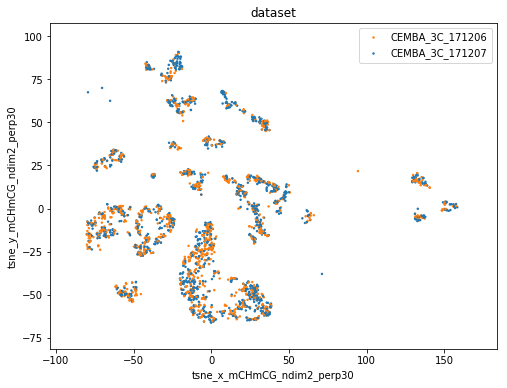

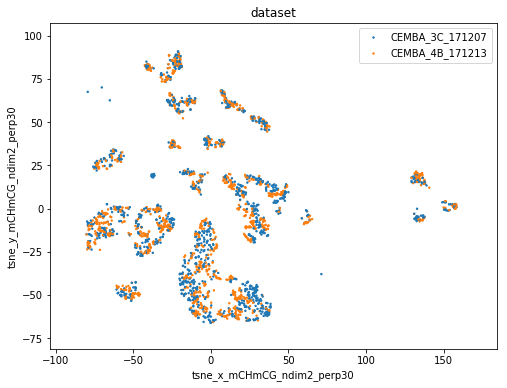

In [42]:
# plot tsne by clustering by datasat
# plot_tsne_labels(df_info, tx=tsne_cols[0], ty=tsne_cols[1], tc='dataset', s=2)
# plot_tsne_labels(df_info, tx=tsne_cols[0], ty=tsne_cols[1], tc='region', s=2)
# plot_tsne_labels(df_info, tx=tsne_cols[0], ty=tsne_cols[1], tc='cell_class', s=2)
# plot_tsne_labels(df_info, tx=tsne_cols[0], ty=tsne_cols[1], tc=annot_col, s=2)
# plot_tsne_labels(df_info, tx=tsne_cols[0], ty=tsne_cols[1], tc=cluster_col, s=2, legend_mode=-1)
plot_tsne_labels(df_info[df_info['region']=='3C'], tx=tsne_cols[0], ty=tsne_cols[1], tc='dataset', s=2)
plot_tsne_labels(df_info[df_info['dataset'].isin(['CEMBA_3C_171207', 'CEMBA_4B_171213'])], 
                 tx=tsne_cols[0], ty=tsne_cols[1], tc='dataset', s=2)

In [7]:
# df_info['genebody_path'] = ['{}/{}/gene_level/genebody_{}.tsv.bgz'.format(PATH_DATASETS, dataset, cell_name) 
#                             for dataset, cell_name in zip(df_info.dataset, df_info.index)]
# pull_genebody_info(ens, ens_genelevel_path, df_info.index.tolist(), df_info['genebody_path'].tolist(), to_file=True)

In [8]:
mc_c_file = os.path.join(ens_path, 'gene_level/genebody_m{}_{}.tsv.bgz'.format(context, ens))
df = snmcseq_utils.read_genebody(mc_c_file, compression='gzip')
print(df.shape)
df.head()

(51772, 8058)


,171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4_CEMBA171206_3C_5_A11_AD002_indexed_mc,171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4_CEMBA171206_3C_5_A11_AD002_indexed_c,171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_A3_AD001_indexed_mc,171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_A3_AD001_indexed_c,171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_G3_AD004_indexed_mc,171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_G3_AD004_indexed_c,171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_E1_AD012_indexed_mc,171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_E1_AD012_indexed_c,171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4_CEMBA171206_3C_5_C3_AD006_indexed_mc,171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4_CEMBA171206_3C_5_C3_AD006_indexed_c,...,171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_3_CEMBA171207_3C_4_B10_AD006_indexed_mc,171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_3_CEMBA171207_3C_4_B10_AD006_indexed_c,171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_3_CEMBA171207_3C_4_F2_AD012_indexed_mc,171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_3_CEMBA171207_3C_4_F2_AD012_indexed_c,171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1_CEMBA171207_3C_2_D6_AD002_indexed_mc,171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_1_CEMBA171207_3C_2_D6_AD002_indexed_c,171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_3_CEMBA171207_3C_4_H5_AD004_indexed_mc,171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_3_CEMBA171207_3C_4_H5_AD004_indexed_c,171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_3_CEMBA171207_3C_4_A9_AD008_indexed_mc,171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171207_3C_3_CEMBA171207_3C_4_A9_AD008_indexed_c
gene_id,,,,,,,,,,,,,,,,,,,,,
ENSMUSG00000102693.1,0,0,0,0,0,0,1,17,5,95,...,0,0,1,26,0,0,0,51,0,0
ENSMUSG00000064842.1,0,0,0,0,0,14,0,13,4,30,...,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000051951.5,4,68,101,8065,92,5093,122,7237,148,9368,...,214,11774,113,6469,97,6491,24,1511,231,12068
ENSMUSG00000102851.1,0,0,2,43,0,0,0,45,0,0,...,0,0,0,0,0,0,0,0,1,42
ENSMUSG00000103377.1,0,0,1,86,0,0,0,0,1,87,...,1,93,4,110,1,19,1,18,2,89


In [9]:
df_mc = df.filter(regex='_mc')
df_c = df.filter(regex='_c')

df_mc.columns = [col[:-len('_mc')] for col in df_mc.columns]
df_c.columns = [col[:-len('_c')] for col in df_c.columns]

print(df_mc.shape)
print(df_c.shape)


(51772, 4029)
(51772, 4029)


In [10]:
# remove low coverage gene

base_call_cutoff = 100 
sufficient_coverage_fraction = 0.94 
condition = (df_c > base_call_cutoff).sum(axis=1) >= sufficient_coverage_fraction*(df.shape[1])/2.0 


print("Matrix size before pruning... "+ str(df.shape))
df_f = df.loc[condition]
print("Matrix size after pruning... "+ str(df_f.shape))

# get mcc matrix with kept bins and nan values for low coverage sites
df_c_nan = df_c.copy()
df_c_nan[df_c < base_call_cutoff] = np.nan
df_mcc = df_mc.loc[condition]/df_c_nan.loc[condition]
print(df_mcc.shape)

# imputation (missing value -> mean value of all cells)
print('Imputing data...')
means = df_mcc.mean(axis=1)
fill_value = pd.DataFrame({col: means for col in df_mcc.columns})
df_mcc.fillna(fill_value, inplace=True)

# add "_mcc" suffix
df_mcc.columns = df_mcc.columns.values + '_mcc'


Matrix size before pruning... (51772, 8058)
Matrix size after pruning... (10867, 8058)
(10867, 4029)
Imputing data...


# End of preprocessing

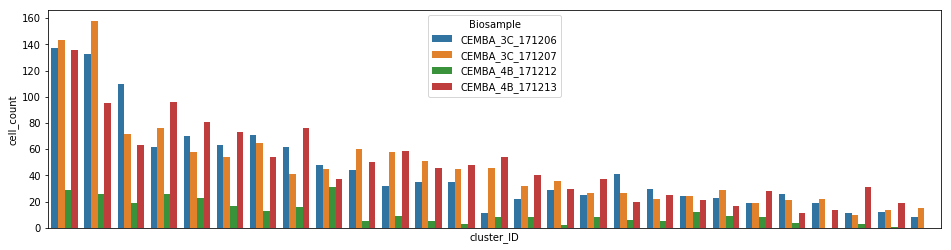

In [11]:
"""
For every cluster, plot biosample related quantities
"""
# cell_count1 = df_info[df_info.Biosample=='MB_v1'].shape[0]
# cell_count2 = df_info[df_info.Biosample=='MB_EA'].shape[0]
# cell_count3 = df_info[df_info.Biosample=='MB_EB'].shape[0]
# print(cell_count1)
# print(cell_count2)
# print(cell_count3)

df_counts = df_info.groupby(['cluster_ID', 'Biosample']).count()['mCH/CH'].to_frame()
df_counts.reset_index(level=['cluster_ID', 'Biosample'], inplace=True)
df_counts.columns = ['cluster_ID', 'Biosample', 'cell_count']

fig, ax = plt.subplots(figsize=(16, 4))
ax = sns.barplot(x="cluster_ID", y="cell_count", hue="Biosample", data=df_counts)
ax.set_xticks([])
plt.show()

In [12]:
df_sample_counts = df_info.groupby('Biosample').count()['mCH/CH'].to_frame()
df_sample_counts.columns = ['tc_biosample']
df_counts_new = pd.merge(df_counts, df_sample_counts, left_on='Biosample', right_index=True)
df_counts_new['cell_ratio'] = df_counts_new.cell_count/df_counts_new.tc_biosample


df_cluster_counts = df_info.groupby('cluster_ID').count()['mCH/CH'].to_frame()
df_cluster_counts.columns = ['tc_cluster']
df_counts_new = pd.merge(df_counts_new, df_cluster_counts, left_on='cluster_ID', right_index=True)
df_counts_new['cell_ratio_cluster'] = df_counts_new.cell_ratio/df_counts_new.tc_cluster

print(df_counts_new.shape)
df_counts_new.head()

(105, 7)


,cluster_ID,Biosample,cell_count,tc_biosample,cell_ratio,tc_cluster,cell_ratio_cluster
0,1,CEMBA_3C_171206,137,1202,0.113977,445,0.000256
1,1,CEMBA_3C_171207,143,1270,0.112598,445,0.000253
2,1,CEMBA_4B_171212,29,296,0.097973,445,0.000220
3,1,CEMBA_4B_171213,136,1261,0.107851,445,0.000242
4,2,CEMBA_3C_171206,133,1202,0.110649,412,0.000269


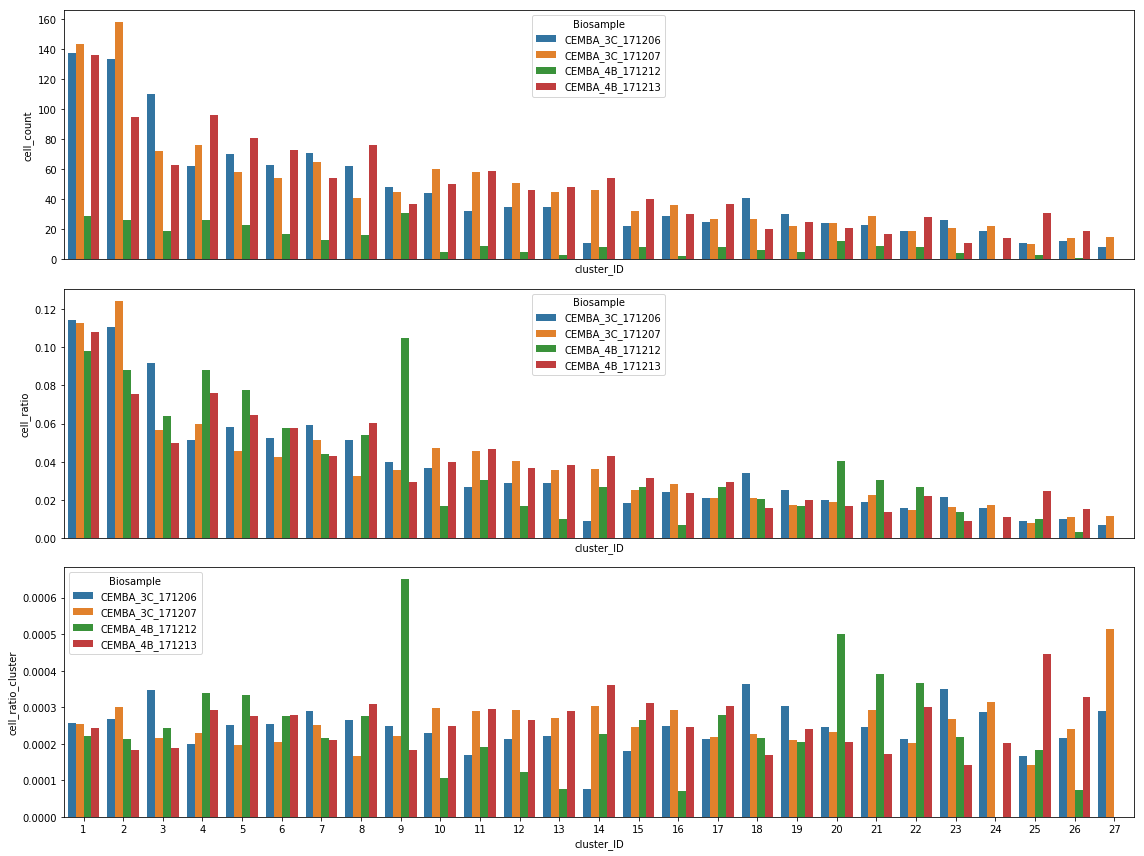

In [13]:
fig, axs = plt.subplots(3, 1, figsize=(16, 12))
ax = axs[0]
sns.barplot(x="cluster_ID", y="cell_count", hue="Biosample", data=df_counts_new, ax=ax)
ax.set_xticks([])
ax = axs[1]
sns.barplot(x="cluster_ID", y="cell_ratio", hue="Biosample", data=df_counts_new, ax=ax)
ax.set_xticks([])
ax = axs[2]
sns.barplot(x="cluster_ID", y="cell_ratio_cluster", hue="Biosample", data=df_counts_new, ax=ax)
# ax.set_xticks([])
fig.tight_layout()
plt.show()

In [14]:
df_counts_2 = df_info.groupby(['cluster_annotation', 'Biosample']).count()['mCH/CH'].to_frame()
df_counts_2 = df_counts_2.reset_index(level=['cluster_annotation', 'Biosample'])
df_counts_2.columns = ['cluster_annotation', 'Biosample', 'cell_count']

df_sample_counts = df_info.groupby('Biosample').count()['mCH/CH'].to_frame()
df_sample_counts.columns = ['tc_biosample']
df_counts_new_2 = pd.merge(df_counts_2, df_sample_counts, left_on='Biosample', right_index=True)
df_counts_new_2['cell_ratio'] = df_counts_new_2.cell_count/df_counts_new_2.tc_biosample

df_cluster_counts = df_info.groupby('cluster_annotation').count()['mCH/CH'].to_frame()
df_cluster_counts.columns = ['tc_cluster']
df_counts_new_2 = pd.merge(df_counts_new_2, df_cluster_counts, left_on='cluster_annotation', right_index=True)
df_counts_new_2['cell_ratio_cluster'] = df_counts_new_2.cell_ratio/df_counts_new_2.tc_cluster

df_counts_new_2.head()

,cluster_annotation,Biosample,cell_count,tc_biosample,cell_ratio,tc_cluster,cell_ratio_cluster
0,mDL-2,CEMBA_3C_171206,134,1202,0.111481,410,0.000272
1,mDL-2,CEMBA_3C_171207,119,1270,0.093701,410,0.000229
2,mDL-2,CEMBA_4B_171212,30,296,0.101351,410,0.000247
3,mDL-2,CEMBA_4B_171213,127,1261,0.100714,410,0.000246
4,mDL-3,CEMBA_3C_171206,8,1202,0.006656,23,0.000289


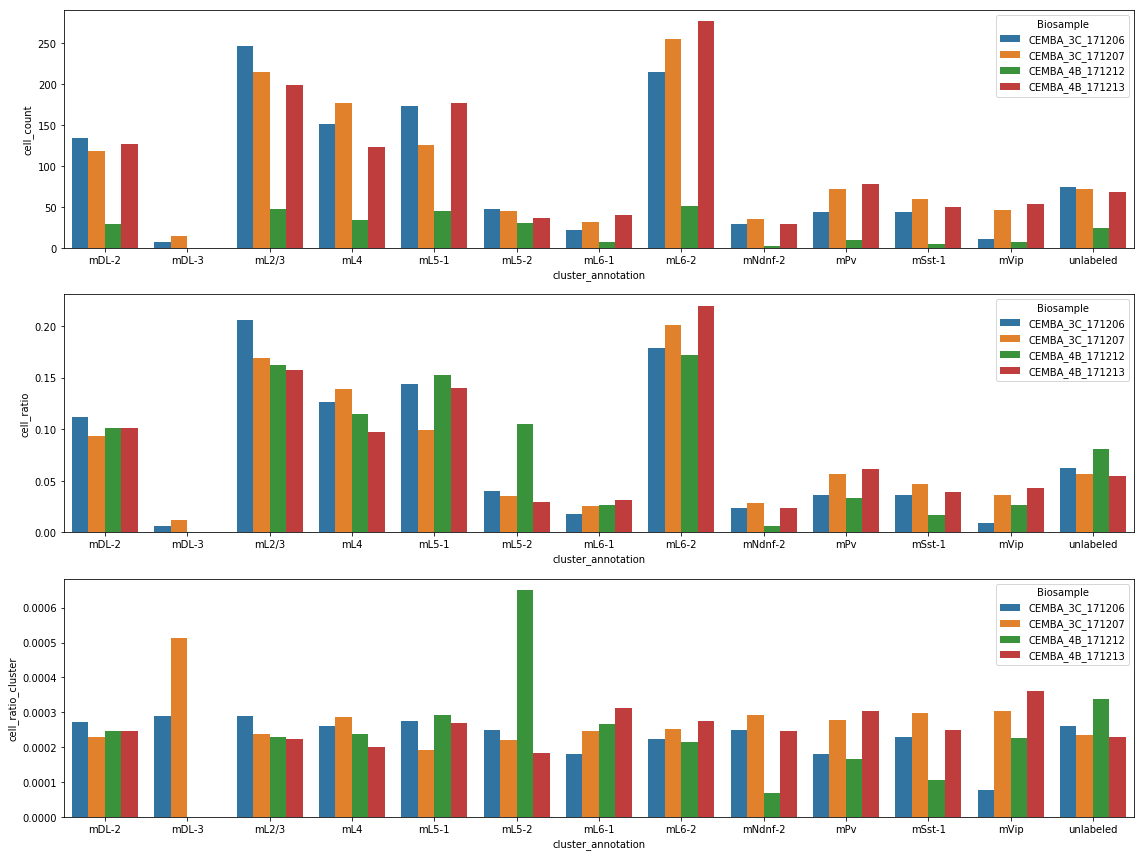

In [15]:
fig, axs = plt.subplots(3, 1, figsize=(16, 12))
ax = axs[0]
sns.barplot(x="cluster_annotation", y="cell_count", hue="Biosample", data=df_counts_new_2, ax=ax)
# ax.set_xticks([])
ax = axs[1]
sns.barplot(x="cluster_annotation", y="cell_ratio", hue="Biosample", data=df_counts_new_2, ax=ax)
# ax.set_xticks([])
ax = axs[2]
sns.barplot(x="cluster_annotation", y="cell_ratio_cluster", hue="Biosample", data=df_counts_new_2, ax=ax)
fig.tight_layout()
plt.show()

In [16]:
df_counts_3 = df_info.groupby(['cell_class', 'Biosample']).count()['mCH/CH'].to_frame()
df_counts_3 = df_counts_3.reset_index(level=['cell_class', 'Biosample'])
df_counts_3.columns = ['cell_class', 'Biosample', 'cell_count']

df_sample_counts = df_info.groupby('Biosample').count()['mCH/CH'].to_frame()
df_sample_counts.columns = ['tc_biosample']
df_counts_new_3 = pd.merge(df_counts_3, df_sample_counts, left_on='Biosample', right_index=True)
df_counts_new_3['cell_ratio'] = df_counts_new_3.cell_count/df_counts_new_3.tc_biosample

df_cluster_counts = df_info.groupby('cell_class').count()['mCH/CH'].to_frame()
df_cluster_counts.columns = ['tc_cluster']
df_counts_new_3 = pd.merge(df_counts_new_3, df_cluster_counts, left_on='cell_class', right_index=True)
df_counts_new_3['cell_ratio_cluster'] = df_counts_new_3.cell_ratio/df_counts_new_3.tc_cluster

df_counts_new_3

,cell_class,Biosample,cell_count,tc_biosample,cell_ratio,tc_cluster,cell_ratio_cluster
0,Ex,CEMBA_3C_171206,999,1202,0.831115,3210,0.000259
1,Ex,CEMBA_3C_171207,984,1270,0.774803,3210,0.000241
2,Ex,CEMBA_4B_171212,247,296,0.834459,3210,0.000260
3,Ex,CEMBA_4B_171213,980,1261,0.777161,3210,0.000242
4,Glia,CEMBA_3C_171206,75,1202,0.062396,240,0.000260
5,Glia,CEMBA_3C_171207,72,1270,0.056693,240,0.000236
6,Glia,CEMBA_4B_171212,24,296,0.081081,240,0.000338
7,Glia,CEMBA_4B_171213,69,1261,0.054718,240,0.000228
8,In,CEMBA_3C_171206,128,1202,0.106489,579,0.000184
9,In,CEMBA_3C_171207,214,1270,0.168504,579,0.000291


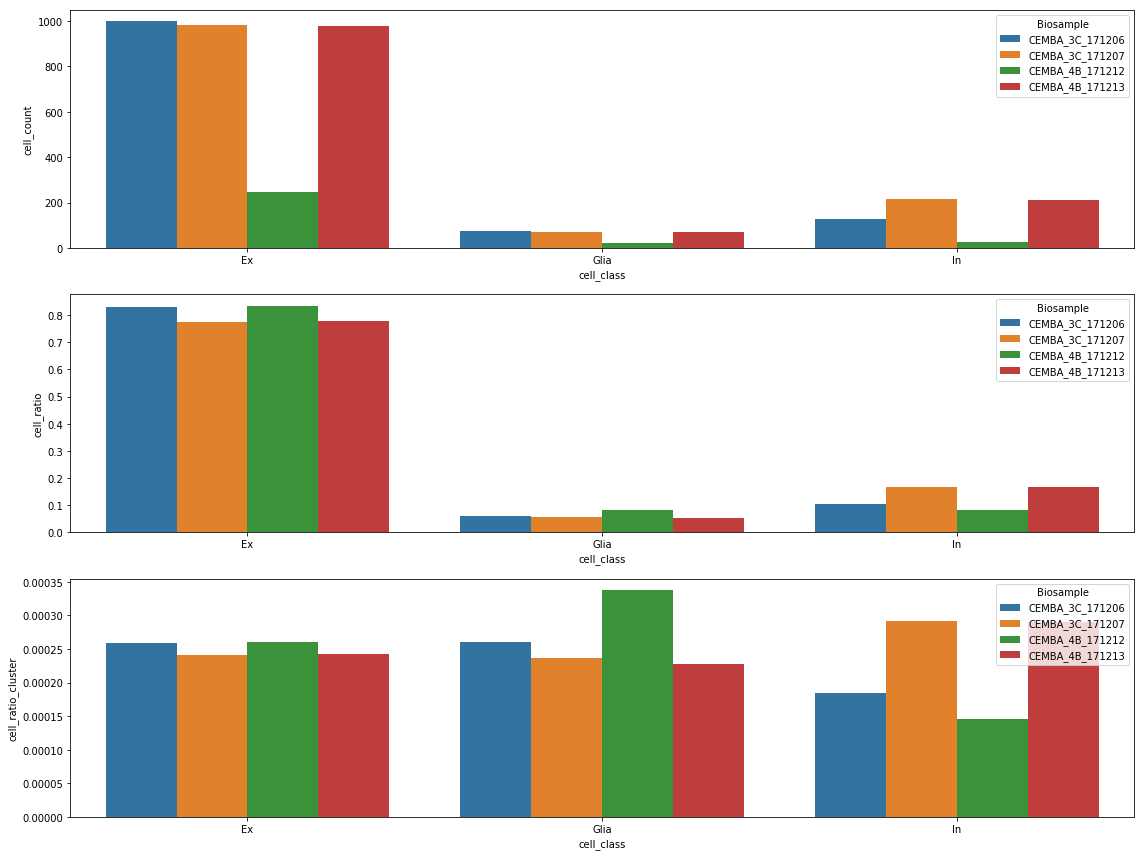

In [17]:
fig, axs = plt.subplots(3, 1, figsize=(16, 12))
ax = axs[0]
sns.barplot(x="cell_class", y="cell_count", hue="Biosample", data=df_counts_new_3, ax=ax)
# ax.set_xticks([])
ax = axs[1]
sns.barplot(x="cell_class", y="cell_ratio", hue="Biosample", data=df_counts_new_3, ax=ax)
# ax.set_xticks([])
ax = axs[2]
sns.barplot(x="cell_class", y="cell_ratio_cluster", hue="Biosample", data=df_counts_new_3, ax=ax)
fig.tight_layout()
plt.show()

# Analysis of variances

In [18]:
def sum_of_square(array):
    dev = array - np.mean(array)
    return np.dot(dev, dev)

# ANOVAs for each gene and each cluster

In [19]:
# ANOVAs for each gene

# sst ssw sr_n

df_sst = pd.DataFrame()
df_ssw = pd.DataFrame()
sr_n = pd.Series()
for idx, df_sub in df_info.groupby('cluster_annotation'):
    cells = df_sub.index.values
    SSt = df_mcc[cells+'_mcc'].apply(sum_of_square, axis=1)
    SSw = 0
    for idx2, df_sub2 in df_sub.groupby('Biosample'):
        cells_bio = df_sub2.index.values
        SSw += df_mcc[cells_bio+'_mcc'].apply(sum_of_square, axis=1)
    df_sst[idx] = SSt 
    df_ssw[idx] = SSw 
    sr_n[idx] = cells.shape[0]
 

In [20]:
# F-stat, p-values

I = df_info['Biosample'].unique().shape[0]
print(str(I) + ' unique categories!')

df_F = ((df_sst - df_ssw)/(I-1))/(df_ssw.divide(sr_n-I, axis=1))
df_p = pd.DataFrame()
for col in df_F.columns:
    d2 = sr_n.loc[col] - I
    df_p[col] = df_F[col].apply(lambda x: stats.f.sf(x, I-1, d2))
df_p.head()

4 unique categories!


,mDL-2,mDL-3,mL2/3,mL4,mL5-1,mL5-2,mL6-1,mL6-2,mNdnf-2,mPv,mSst-1,mVip,unlabeled
gene_id,,,,,,,,,,,,,
ENSMUSG00000051951.5,5.810763e-03,0.749755,5.455268e-09,0.702979,0.000004,0.969846,0.123985,1.514088e-08,0.046760,0.000007,0.089992,0.563092,1.461448e-01
ENSMUSG00000089699.1,7.312265e-01,0.892182,2.274747e-04,0.949023,0.495452,0.363658,0.357889,1.599688e-04,0.705820,0.002863,0.676130,0.359965,2.120393e-01
ENSMUSG00000102343.1,1.931403e-01,0.924193,1.971658e-01,0.991796,0.004846,0.015565,0.044515,8.972534e-02,0.648506,0.251485,0.598181,0.778135,1.419398e-01
ENSMUSG00000025900.12,6.229291e-07,0.973878,2.078365e-02,0.118084,0.016319,0.269122,0.004674,1.165088e-04,0.195021,0.003694,0.001324,0.552137,2.236970e-10
ENSMUSG00000025903.14,1.079398e-01,0.931202,2.427238e-03,0.318388,0.230742,0.761833,0.448315,2.266010e-01,0.481283,0.600564,0.262157,0.117413,2.468258e-01


In [21]:
df_sst.head()

,mDL-2,mDL-3,mL2/3,mL4,mL5-1,mL5-2,mL6-1,mL6-2,mNdnf-2,mPv,mSst-1,mVip,unlabeled
gene_id,,,,,,,,,,,,,
ENSMUSG00000051951.5,0.003155,0.000133,0.007586,0.004071,0.003235,0.009184,0.001218,0.009030,0.000561,0.001176,0.001033,0.003810,0.009370
ENSMUSG00000089699.1,0.013235,0.001224,0.027172,0.015571,0.014551,0.026187,0.005126,0.026317,0.002754,0.005711,0.003633,0.010426,0.019922
ENSMUSG00000102343.1,0.010750,0.000281,0.022699,0.011039,0.017612,0.012516,0.003743,0.025495,0.006714,0.015043,0.011686,0.007448,0.002695
ENSMUSG00000025900.12,0.005832,0.000197,0.017599,0.005631,0.012105,0.003804,0.001648,0.014243,0.003372,0.007025,0.006625,0.004589,0.000579
ENSMUSG00000025903.14,0.023018,0.001677,0.044494,0.020183,0.042870,0.017871,0.007238,0.055832,0.004084,0.010650,0.012680,0.007728,0.005791


In [22]:
# eta-squard and omega squared
df_eta = 1 - df_ssw/df_sst

# om_sqrd = (SSbetween - (DFbetween * MSwithin))/(SStotal + MSwithin)
df_ome = (df_sst - df_ssw - (I-1)*df_ssw.divide(sr_n-I, axis=1))/(df_sst + df_ssw.divide(sr_n-I, axis=1))


def order_df_res(df_res):
    df_res_ordered = pd.DataFrame()
    for col in df_res.columns:
        df_res_ordered[col] = df_res[col].sort_values(ascending=False).values
    return df_res_ordered

## Plots of ANOVA

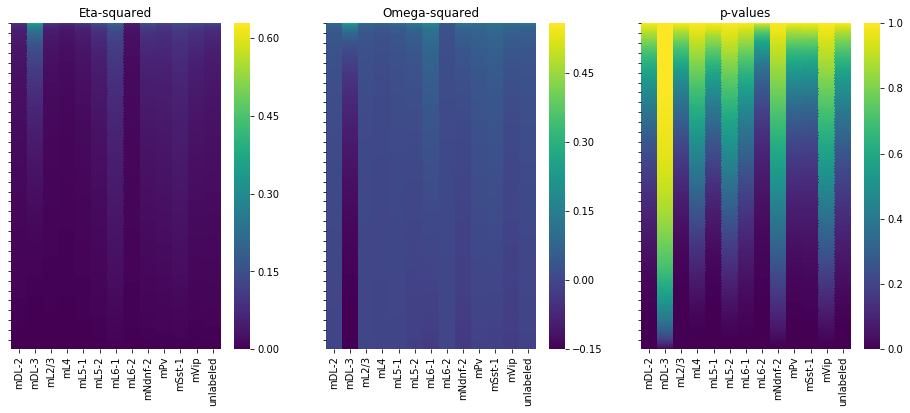

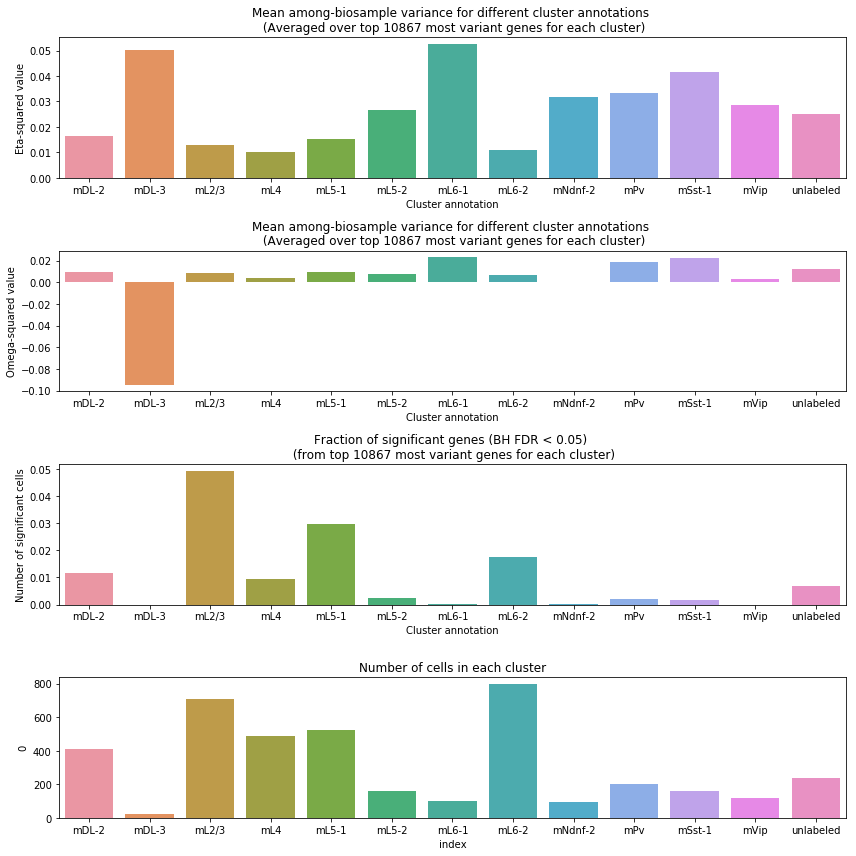

In [23]:
# eta-squared, omega-squared, and p-values 

df_res1 = df_eta
df_res2 = df_ome
df_res3 = df_p
n_top = df_res1.shape[0] 

df_res_ordered1 = order_df_res(df_res1)
df_res_ordered2 = order_df_res(df_res2)
df_res_ordered3 = order_df_res(df_res3)
    
df_plot1 = df_res_ordered1.iloc[:n_top, :].mean(axis=0).to_frame()
df_plot1.reset_index(level=0, inplace=True)
df_plot1.columns = ['Cluster annotation', 'Eta-squared value']

df_plot2 = df_res_ordered2.iloc[:n_top, :].mean(axis=0).to_frame()
df_plot2.reset_index(level=0, inplace=True)
df_plot2.columns = ['Cluster annotation', 'Omega-squared value']

# number of variant genes
df_plot3 = pd.Series()
for col in df_p.columns:
    rejs, *dis = multipletests(df_p[col], alpha=0.05, method='hs')
    df_plot3[col] = rejs.sum()
df_plot3 = (df_plot3/df_p.shape[0]).to_frame().reset_index()
df_plot3.columns = ['Cluster annotation', 'Number of significant cells']


fig, axs = plt.subplots(1, 3, figsize=(16, 6))
ax = axs[0]
sns.heatmap(df_res_ordered1.iloc[:n_top, :], cmap='viridis', ax=ax)
ax.set_title('Eta-squared')
ax.set_yticklabels([])
ax = axs[1]
sns.heatmap(df_res_ordered2.iloc[:n_top, :], cmap='viridis', ax=ax)
ax.set_title('Omega-squared')
ax.set_yticklabels([])
ax = axs[2]
sns.heatmap(df_res_ordered3.iloc[:n_top, :], cmap='viridis', ax=ax)
ax.set_title('p-values')
ax.set_yticklabels([])
plt.show()

fig, axs = plt.subplots(4, 1, figsize=(12, 12))
ax = axs[0]
sns.barplot(x='Cluster annotation', y='Eta-squared value', data=df_plot1, ax=ax)
ax.set_title('Mean among-biosample variance for different cluster annotations \n (Averaged over top %d most variant genes for each cluster)' % n_top)
ax = axs[1]
sns.barplot(x='Cluster annotation', y='Omega-squared value', data=df_plot2, ax=ax)
ax.set_title('Mean among-biosample variance for different cluster annotations \n (Averaged over top %d most variant genes for each cluster)' % n_top)
ax = axs[2]
sns.barplot(x='Cluster annotation', y='Number of significant cells', data=df_plot3, ax=ax)
ax.set_title('Fraction of significant genes (BH FDR < 0.05) \n (from top %d most variant genes for each cluster)' % n_top)
ax = axs[3]
sns.barplot(x='index', y=0, data=sr_n.to_frame().reset_index(), ax=ax)
ax.set_title('Number of cells in each cluster')
fig.tight_layout()
plt.show()



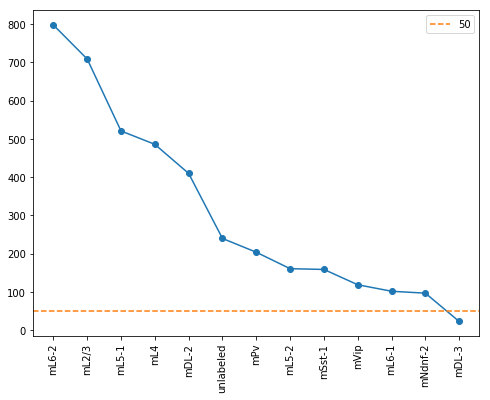

mDL-2        410
mL2/3        709
mL4          486
mL5-1        521
mL5-2        161
mL6-1        102
mL6-2        798
mNdnf-2       97
mPv          204
mSst-1       159
mVip         119
unlabeled    240
dtype: int64

In [24]:
# number of cells in each cluster

sr_n_sorted = sr_n.sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(8, 6))
# sns.barplot(x='index', y=0, data=sr_n.sort_values(ascending=False).to_frame().reset_index(), ax=ax)
# ax.set_title('Number of cells in each cluster')

ax.plot(sr_n_sorted.values, '-o')
ax.set_xticklabels(sr_n_sorted.index.values, rotation=90)
ax.set_xticks([i for i in range(sr_n.shape[0])])
ax.axhline(y=50, ls='dashed', color='C1', label='50')
ax.legend()
plt.show()

sr_n_tr = sr_n.loc[sr_n.index.isin(sr_n_sorted[(sr_n_sorted > 50)].index)]
sr_n_tr

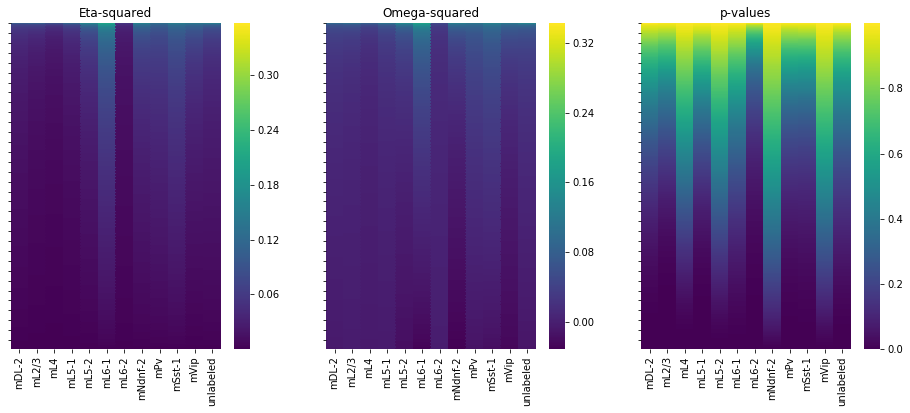

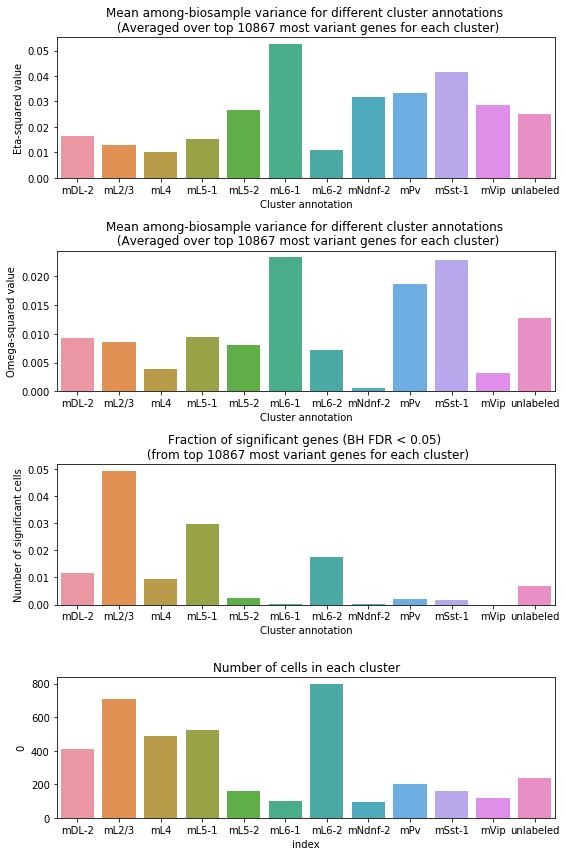

In [25]:
# rerun with truncated set of celltypes

# eta-squared, omega-squared, and p-values 

cell_types_tr = sr_n_tr.index.values  

df_res1 = df_eta[cell_types_tr]
df_res2 = df_ome[cell_types_tr]
df_res3 = df_p[cell_types_tr]
n_top = df_res1.shape[0] 
# n_top = 50 

df_res_ordered1 = order_df_res(df_res1)
df_res_ordered2 = order_df_res(df_res2)
df_res_ordered3 = order_df_res(df_res3)
    
df_plot1 = df_res_ordered1.iloc[:n_top, :].mean(axis=0).to_frame()
df_plot1.reset_index(level=0, inplace=True)
df_plot1.columns = ['Cluster annotation', 'Eta-squared value']

df_plot2 = df_res_ordered2.iloc[:n_top, :].mean(axis=0).to_frame()
df_plot2.reset_index(level=0, inplace=True)
df_plot2.columns = ['Cluster annotation', 'Omega-squared value']

# number of variant genes
df_plot3 = pd.Series()
for col in df_res3.columns:
    rejs, *dis = multipletests(df_res3[col], alpha=0.05, method='hs')
    df_plot3[col] = rejs.sum()
df_plot3 = (df_plot3/df_p.shape[0]).to_frame().reset_index()
df_plot3.columns = ['Cluster annotation', 'Number of significant cells']


fig, axs = plt.subplots(1, 3, figsize=(16, 6))
ax = axs[0]
sns.heatmap(df_res_ordered1.iloc[:n_top, :], cmap='viridis', ax=ax)
ax.set_title('Eta-squared')
ax.set_yticklabels([])
ax = axs[1]
sns.heatmap(df_res_ordered2.iloc[:n_top, :], cmap='viridis', ax=ax)
ax.set_title('Omega-squared')
ax.set_yticklabels([])
ax = axs[2]
sns.heatmap(df_res_ordered3.iloc[:n_top, :], cmap='viridis', ax=ax)
ax.set_title('p-values')
ax.set_yticklabels([])
plt.show()

fig, axs = plt.subplots(4, 1, figsize=(8, 12))
ax = axs[0]
sns.barplot(x='Cluster annotation', y='Eta-squared value', data=df_plot1, ax=ax)
ax.set_title('Mean among-biosample variance for different cluster annotations \n (Averaged over top %d most variant genes for each cluster)' % n_top)
ax = axs[1]
sns.barplot(x='Cluster annotation', y='Omega-squared value', data=df_plot2, ax=ax)
ax.set_title('Mean among-biosample variance for different cluster annotations \n (Averaged over top %d most variant genes for each cluster)' % n_top)
ax = axs[2]
sns.barplot(x='Cluster annotation', y='Number of significant cells', data=df_plot3, ax=ax)
ax.set_title('Fraction of significant genes (BH FDR < 0.05) \n (from top %d most variant genes for each cluster)' % n_top)
ax = axs[3]
sns.barplot(x='index', y=0, data=sr_n_tr.to_frame().reset_index(), ax=ax)
ax.set_title('Number of cells in each cluster')
fig.tight_layout()
plt.show()


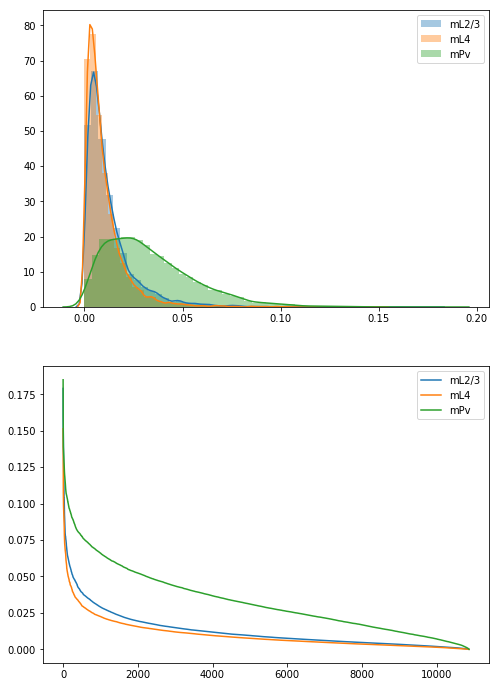

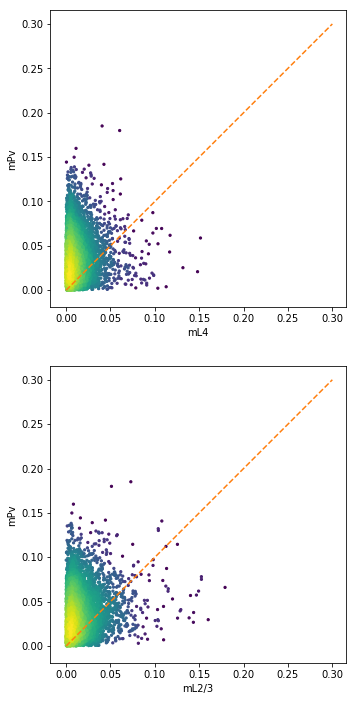

In [26]:
# eta-squared 
df_res = df_eta 
n_top = df_res.shape[0] 

df_res_ordered = pd.DataFrame()
for col in df_res.columns:
    df_res_ordered[col] = df_res[col].sort_values(ascending=False).values
    
fig, axs = plt.subplots(2, 1, figsize=(8, 12))
ax = axs[0]
sns.distplot(df_res['mL2/3'].values, ax=ax, label='mL2/3')
sns.distplot(df_res['mL4'].values, ax=ax, label='mL4')
# sns.distplot(df_res['hL5-2'].values, ax=ax, label='hL5-2')
sns.distplot(df_res['mPv'].values, ax=ax, label='mPv')
# sns.distplot(df_res['hNdnf'].values, ax=ax, label='hNdnf')
ax.legend()

ax = axs[1]
ax.plot(df_res_ordered['mL2/3'].values, label='mL2/3')
ax.plot(df_res_ordered['mL4'].values, label='mL4')
# ax.plot(df_res_ordered['hL5-2'].values, label='hL5-2')
ax.plot(df_res_ordered['mPv'].values, label='mPv')
# ax.plot(df_res_ordered['hNdnf'].values, label='hNdnf')
# ax.set_yscale('log')
ax.legend()
plt.show()


fig, axs = plt.subplots(2, 1, figsize=(8, 12))
ax = axs[0]
xy = np.vstack([df_res['mL4'].values, df_res['mPv'].values]) 
z = gaussian_kde(xy)(xy)
ax.scatter(df_res['mL4'].values, df_res['mPv'].values, c=np.log10(z), s=5)
ax.set_xlabel('mL4')
ax.set_ylabel('mPv')
line_x = np.arange(0, 0.4, 0.1)
line_y = np.arange(0, 0.4, 0.1)
ax.plot(line_x, line_y, '--', color='C1')
ax.set_aspect('equal')

ax = axs[1]
xy = np.vstack([df_res['mL2/3'].values, df_res['mPv'].values]) 
z = gaussian_kde(xy)(xy)
ax.scatter(df_res['mL2/3'].values, df_res['mPv'].values, c=np.log10(z), s=5)
ax.set_xlabel('mL2/3')
ax.set_ylabel('mPv')
line_x = np.arange(0, 0.4, 0.1)
line_y = np.arange(0, 0.4, 0.1)
ax.plot(line_x, line_y, '--', color='C1')
ax.set_aspect('equal')
plt.show()



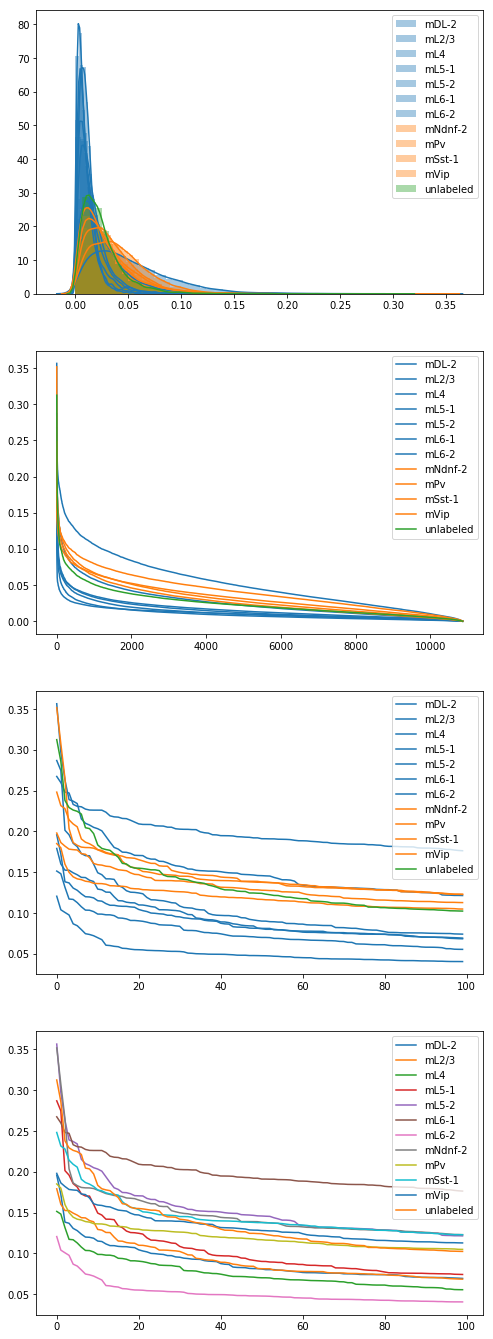

In [27]:
# eta-squared

# df_cell_class.loc[cell_types_tr].groupby('cell_class')

cell_types_tr = sr_n_tr.index.tolist()
df_res = df_eta[cell_types_tr] 
n_top = df_res.shape[0] 

df_res_ordered = pd.DataFrame()
for col in df_res.columns:
    df_res_ordered[col] = df_res[col].sort_values(ascending=False).values
    
fig, axs = plt.subplots(4, 1, figsize=(8, 6*4))
ax = axs[0]
for col in df_res.columns:
    if df_cell_class.loc[col, 'cell_class'] == 'Ex':
        sns.distplot(df_res[col].values, ax=ax, label=col, color='C0')
    elif df_cell_class.loc[col, 'cell_class'] == 'In':
        sns.distplot(df_res[col].values, ax=ax, label=col, color='C1')
    elif df_cell_class.loc[col, 'cell_class'] == 'Glia':
        sns.distplot(df_res[col].values, ax=ax, label=col, color='C2')
ax.legend()

ax = axs[1]
for col in df_res.columns:
    if df_cell_class.loc[col, 'cell_class'] == 'Ex':
        ax.plot(df_res_ordered[col].values, label=col, color='C0')
    elif df_cell_class.loc[col, 'cell_class'] == 'In':
        ax.plot(df_res_ordered[col].values, label=col, color='C1')
    elif df_cell_class.loc[col, 'cell_class'] == 'Glia':
        ax.plot(df_res_ordered[col].values, label=col, color='C2')
ax.legend()

ax = axs[2]
n_tops = 100
for col in df_res.columns:
    if df_cell_class.loc[col, 'cell_class'] == 'Ex':
        ax.plot(df_res_ordered[col].values[:n_tops], label=col, color='C0')
    elif df_cell_class.loc[col, 'cell_class'] == 'In':
        ax.plot(df_res_ordered[col].values[:n_tops], label=col, color='C1')
    elif df_cell_class.loc[col, 'cell_class'] == 'Glia':
        ax.plot(df_res_ordered[col].values[:n_tops], label=col, color='C2')
ax.legend()

ax = axs[3]
n_tops = 100
for col in df_res.columns:
    ax.plot(df_res_ordered[col].values[:n_tops], label=col)
#     if df_cell_class.loc[col, 'cell_class'] == 'Ex':
#         ax.plot(df_res_ordered[col].values[:n_tops], label=col, color='C0')
#     elif df_cell_class.loc[col, 'cell_class'] == 'In':
#         ax.plot(df_res_ordered[col].values[:n_tops], label=col, color='C1')
#     elif df_cell_class.loc[col, 'cell_class'] == 'Glia':
#         ax.plot(df_res_ordered[col].values[:n_tops], label=col, color='C2')
ax.legend()
plt.show()



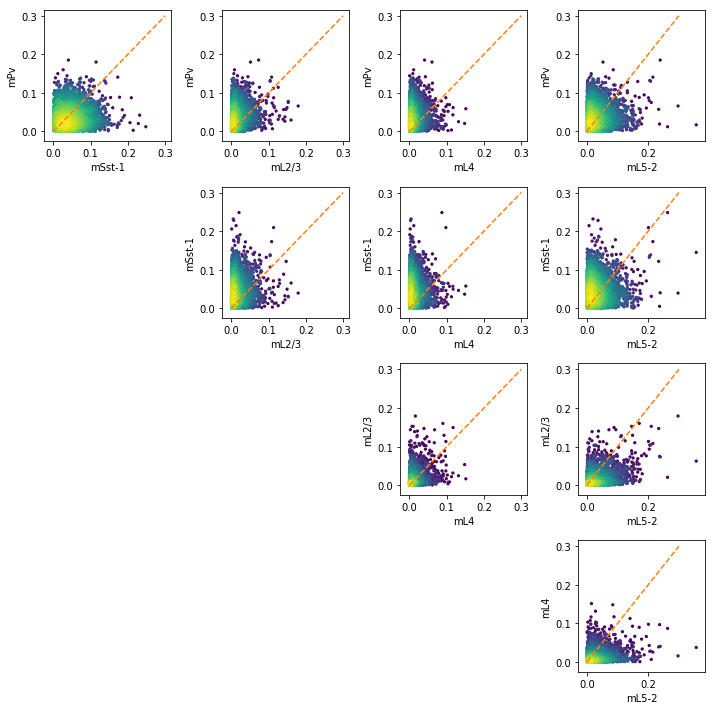

In [28]:
# hPv-1, hSst-2, hL2/3, hL4, hL5-2

cell_types_tr2 = ['mPv', 'mSst-1', 'mL2/3', 'mL4', 'mL5-2']
n = len(cell_types_tr2)

fig, axs = plt.subplots(n, n, figsize=(12, 12))
for i, j in zip(*np.tril_indices_from(axs, k=0)):
    axs[i, j].set_visible(False)
for i, j in zip(*np.triu_indices_from(axs, k=1)):
    ax = axs[i, j]
    cti = cell_types_tr2[j]
    ctj = cell_types_tr2[i]
    xy = np.vstack([df_res[cti].values, df_res[ctj].values]) 
    z = gaussian_kde(xy)(xy)
    ax.scatter(df_res[cti].values, df_res[ctj].values, c=np.log10(z), s=5)
    ax.set_xlabel(cti)
    ax.set_ylabel(ctj)
    line_x = np.arange(0, 0.4, 0.1)
    line_y = np.arange(0, 0.4, 0.1)
    ax.plot(line_x, line_y, '--', color='C1')
    ax.set_aspect('auto')
    
fig.tight_layout()
plt.show()



# Look at one cell type (hL4)

In [29]:
# repeat with different n 

# take top n genes for hL4

# classifier LDA   

# evaluate

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn import metrics 
from sklearn.model_selection import KFold

# number of cells from each biosample

def get_data(celltype):
    cells = df_info[df_info.cluster_annotation==celltype].index.values
#     cells_v1 = df_info[(df_info.cluster_annotation==celltype) & (df_info.Biosample=='MB_v1')].index.values
#     cells_EA = df_info[(df_info.cluster_annotation==celltype) & (df_info.Biosample=='MB_EA')].index.values
#     cells_EB = df_info[(df_info.cluster_annotation==celltype) & (df_info.Biosample=='MB_EB')].index.values
#     print(np.asarray([cells_v1.shape[0], cells_EA.shape[0], cells_EB.shape[0]])/cells.shape[0])

    # generate data
    cells = df_info[df_info['cluster_annotation']==celltype].index.values
    y = df_info.loc[cells, 'Biosample']
    X0 = df_mcc.loc[df_p.sample(frac=1).index.values, cells+'_mcc'].T 
    X0.index = [cell[:-len('_mcc')] for cell in X0.index]
    X1 = df_mcc.loc[df_p[celltype].sort_values().index.values, cells+'_mcc'].T 
    X1.index = [cell[:-len('_mcc')] for cell in X1.index]
    df_xy0 = pd.merge(X0, y.to_frame(), left_index=True, right_index=True)
    df_xy1 = pd.merge(X1, y.to_frame(), left_index=True, right_index=True)
#     print(df_xy0.shape)
#     print(df_xy1.shape)
    return df_xy0, df_xy1
    

In [30]:

def LDA_xvalid(df_xy, n_splits=5, n_tops=np.arange(1, 100, 2), classifier='LDA'):
    """
    X = regex="^ENS"
    y = "Biosample"
    
    """
    # 5-fold cv with LDA
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    # n_tops = [10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000]

    mean_accs = []
    mean_f1_micros = []
    mean_f1_macros = []
    split_scheme = list(kf.split(df_xy))
    for n_top in n_tops:
        accs = []
        f1_micros = []
        f1_macros = []
        for i, (train_index, test_index) in enumerate(split_scheme):
            X_train = df_xy.iloc[train_index, :n_top].filter(regex='^ENS')
            X_test = df_xy.iloc[test_index, :n_top].filter(regex='^ENS')
            y_train = df_xy.iloc[train_index, :].Biosample
            y_test = df_xy.iloc[test_index, :].Biosample

            # train LDA model
            if classifier == 'LDA':
                lda = LDA().fit(X_train, y_train)
                y_pred = lda.predict(X_test)
            elif classifier == 'RFC':
                rfc = RFC(n_estimators=10, random_state=1).fit(X_train, y_train)
                y_pred = rfc.predict(X_test)

            # evaluate
            acc = metrics.accuracy_score(y_test, y_pred)
            f1_micro = metrics.f1_score(y_test, y_pred, average='micro')
            f1_macro = metrics.f1_score(y_test, y_pred, average='macro')
            accs.append(acc)
            f1_micros.append(f1_micro)
            f1_macros.append(f1_macro)

    #         if i == 0:
    #             conf_mat = metrics.confusion_matrix(y_test, y_pred)
    #             print(conf_mat)


        mean_acc = np.mean(accs)
        mean_f1_micro = np.mean(f1_micros)
        mean_f1_macro = np.mean(f1_macros)

        mean_accs.append(mean_acc)
        mean_f1_micros.append(mean_f1_micro)
        mean_f1_macros.append(mean_f1_macro)

    return mean_accs, mean_f1_micros, mean_f1_macros


/cndd/fangming/venvs/venv_banjo_snmcseq/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/cndd/fangming/venvs/venv_banjo_snmcseq/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/cndd/fangming/venvs/venv_banjo_snmcseq/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/cndd/fangming/venvs/venv_banjo_snmcseq/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'prec

/cndd/fangming/venvs/venv_banjo_snmcseq/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/cndd/fangming/venvs/venv_banjo_snmcseq/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/cndd/fangming/venvs/venv_banjo_snmcseq/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/cndd/fangming/venvs/venv_banjo_snmcseq/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'prec

/cndd/fangming/venvs/venv_banjo_snmcseq/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/cndd/fangming/venvs/venv_banjo_snmcseq/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/cndd/fangming/venvs/venv_banjo_snmcseq/lib/python3.4/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/cndd/fangming/venvs/venv_banjo_snmcseq/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'pred

/cndd/fangming/venvs/venv_banjo_snmcseq/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/cndd/fangming/venvs/venv_banjo_snmcseq/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/cndd/fangming/venvs/venv_banjo_snmcseq/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/cndd/fangming/venvs/venv_banjo_snmcseq/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'prec

/cndd/fangming/venvs/venv_banjo_snmcseq/lib/python3.4/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/cndd/fangming/venvs/venv_banjo_snmcseq/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/cndd/fangming/venvs/venv_banjo_snmcseq/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/cndd/fangming/venvs/venv_banjo_snmcseq/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'pred

/cndd/fangming/venvs/venv_banjo_snmcseq/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/cndd/fangming/venvs/venv_banjo_snmcseq/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/cndd/fangming/venvs/venv_banjo_snmcseq/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/cndd/fangming/venvs/venv_banjo_snmcseq/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'prec

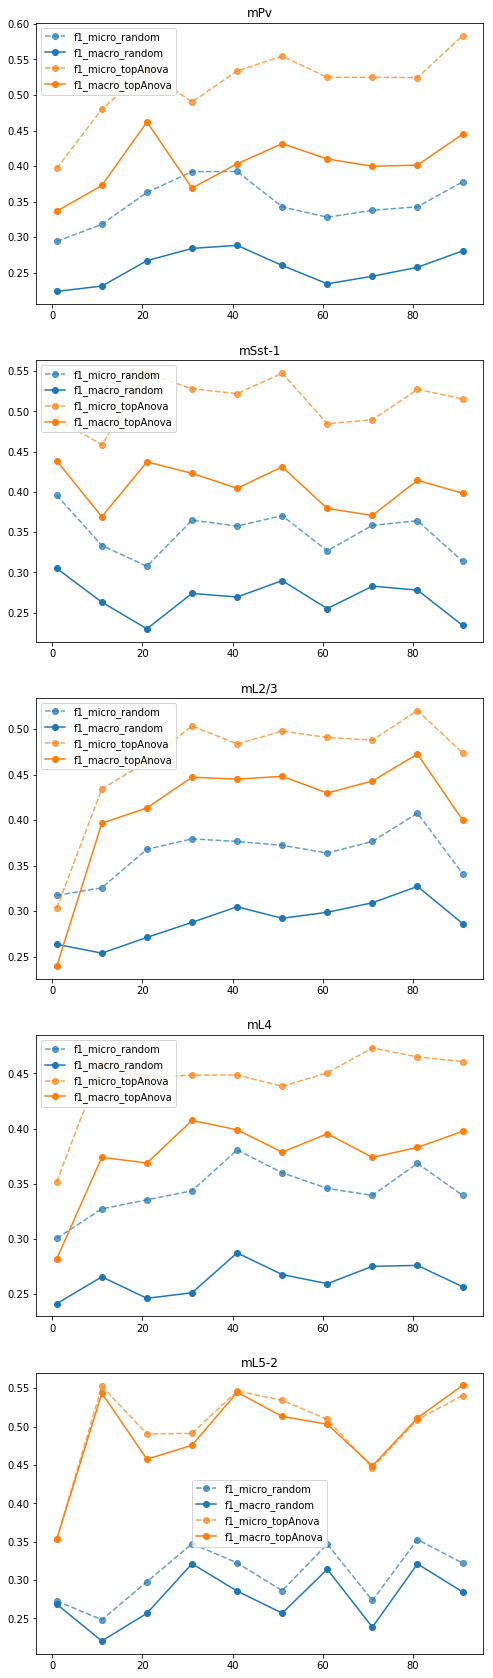

In [31]:
# cell_types_tr2 = ['hPv-1', 'hSst-2', 'hL2/3', 'hL4', 'hL5-2']
n = len(cell_types_tr2)
n_tops = np.arange(1, 100, 10)

fig, axs = plt.subplots(n, 1, figsize=(8, 6*n))
for celltype, ax in zip(cell_types_tr2, axs):
    
    df_xy0, df_xy1 = get_data(celltype)
    accs0, f1_micros0, f1_macros0 = LDA_xvalid(df_xy0, n_tops=n_tops, classifier='RFC')
    accs1, f1_micros1, f1_macros1 = LDA_xvalid(df_xy1, n_tops=n_tops, classifier='RFC')

    ax.plot(n_tops, f1_micros0, '--o', label='f1_micro_random', color='C0', alpha=0.7)
    ax.plot(n_tops, f1_macros0, '-o', label='f1_macro_random', color='C0')
    ax.plot(n_tops, f1_micros1, '--o', label='f1_micro_topAnova', color='C1', alpha=0.7)
    ax.plot(n_tops, f1_macros1, '-o', label='f1_macro_topAnova', color='C1')
    ax.set_title(celltype)
    ax.legend()
plt.show()

In [32]:
# What are the top 30 genes?
n_top = 30
sr_top_genes = df_gene.loc[df_p['mPv'].sort_values().index.values[:n_top], 'geneName']
sr_top_genes.to_frame()

NameError: name 'df_gene' is not defined

In [33]:
# Look at those genes in detail
# tsne and boxplot

celltype='mPv'
cells = df_info[df_info['cluster_annotation']==celltype].index.values
X1 = df_mcc.loc[df_p[celltype].sort_values().index.values, cells+'_mcc'].T 
X1.index = [ind[:-len('_mcc')] for ind in X1.index]

for gene_id, gene_name in sr_top_genes.iteritems():
    df_plot = pd.merge(df_info, X1[[gene_id]], left_index=True, right_index=True) 
    tsne_and_boxplot(df_plot, tc=gene_id, bx='Biosample', by=gene_id,
                    output=None, show=True, close=False, 
                    title=('Genebody mCH: %s' % gene_name), 
                    figsize=(6,8),
                    t_xlim=None, t_ylim=None, b_xlim=None, b_ylim=None, 
                    low_p=5, hi_p=95)


NameError: name 'sr_top_genes' is not defined

In [34]:
def LDA_pca_xvalid(X, y, n_splits=5, classifier='LDA'):
    """
    X = regex="^\("
    y = "Biosample"
    
    """
    # 5-fold cv with LDA
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    mean_accs = []
    mean_f1_micros = []
    mean_f1_macros = []
    split_scheme = list(kf.split(y))
 
    accs = []
    f1_micros = []
    f1_macros = []
    for i, (train_index, test_index) in enumerate(split_scheme):
        X_train = X[train_index] 
        X_test = X[test_index] 
        y_train = y[train_index] 
        y_test = y[test_index] 

        # train LDA model
        if classifier == 'LDA':
            res_fit = LDA().fit(X_train, y_train)
            y_pred = res_fit.predict(X_test)
        elif classifier == 'RFC':
            res_fit = RFC(n_estimators=10, random_state=1).fit(X_train, y_train)
            y_pred = res_fit.predict(X_test)

        # evaluate
        acc = metrics.accuracy_score(y_test, y_pred)
        f1_micro = metrics.f1_score(y_test, y_pred, average='micro')
        f1_macro = metrics.f1_score(y_test, y_pred, average='macro')
        accs.append(acc)
        f1_micros.append(f1_micro)
        f1_macros.append(f1_macro)

#         if i == 0:
#             conf_mat = metrics.confusion_matrix(y_test, y_pred)
#             print(conf_mat)


    mean_acc = np.mean(accs)
    mean_f1_micro = np.mean(f1_micros)
    mean_f1_macro = np.mean(f1_macros)

    return mean_acc, mean_f1_micro, mean_f1_macro

In [35]:
# PCA regression
# top n PCs

n_tops = [5, 10, 20, 30, 40, 50]

cell_types_tr2 = sr_n_tr.index.values


res_dct = OrderedDict()
for celltype in cell_types_tr2:
    df_xy0, df_xy1 = get_data(celltype)
    X = df_xy1.filter(regex='^ENS').values
    y = df_xy1.Biosample.values
    
    accs = []
    f1_mis = []
    f1_mas = []
    for n_top in n_tops:
        
        pca = PCA(n_components=n_top)
        pcX = pca.fit_transform(X)

        acc, f1_mi, f1_ma = LDA_pca_xvalid(pcX, y, classifier='LDA')
        accs.append(acc)
        f1_mis.append(f1_mi)
        f1_mas.append(f1_ma)
    
    res_dct[celltype] = (accs, f1_mis, f1_mas) 

/cndd/fangming/venvs/venv_banjo_snmcseq/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/cndd/fangming/venvs/venv_banjo_snmcseq/lib/python3.4/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/cndd/fangming/venvs/venv_banjo_snmcseq/lib/python3.4/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


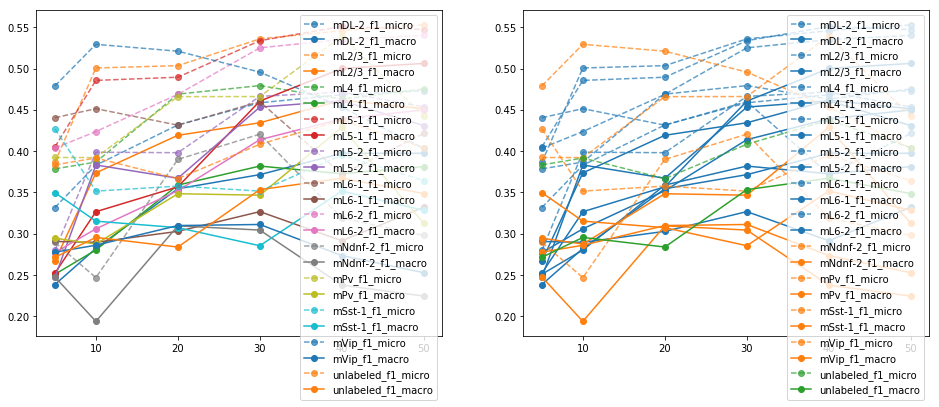

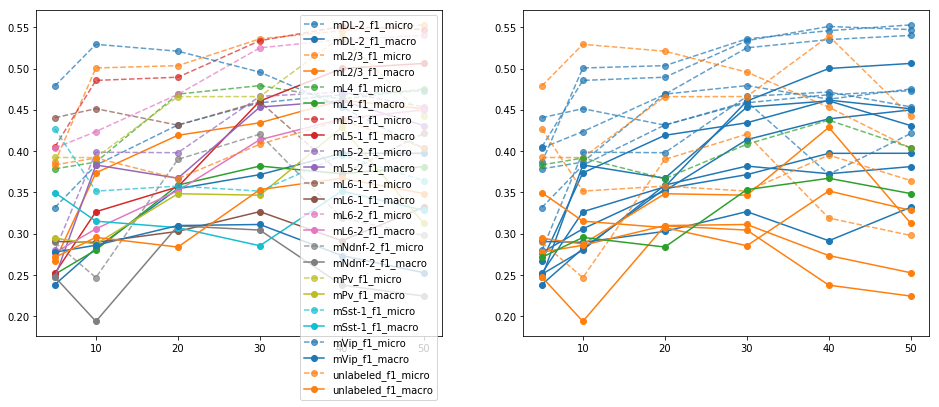

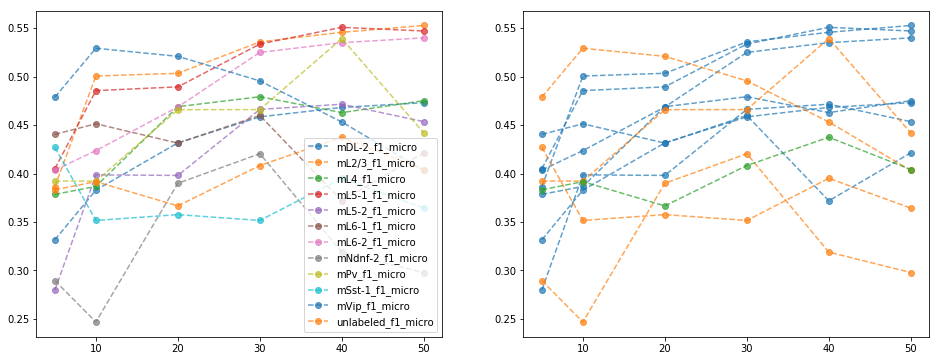

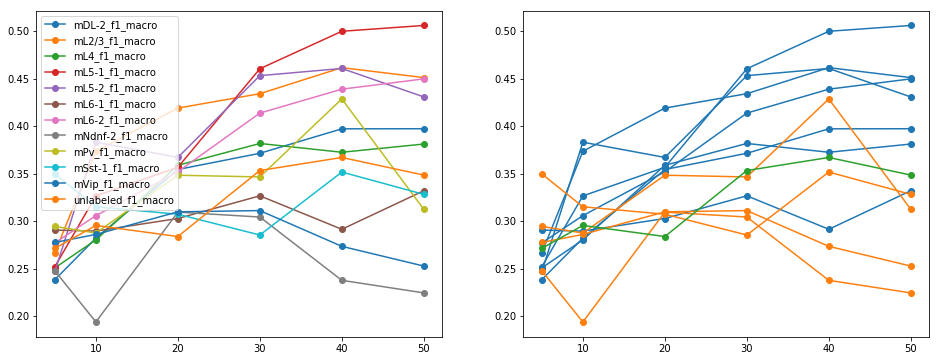

In [36]:
cell_types_tr2 = sr_n_tr.index.values
n_tops = [5, 10, 20, 30, 40, 50]

colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']

fig, axs = plt.subplots(1, 2, figsize=(16, 6))
ax = axs[0]
for i, celltype in enumerate(cell_types_tr2):
    ax.plot(n_tops, res_dct[celltype][1], '--o', color=colors[i%len(colors)], label='{}_f1_micro'.format(celltype), alpha=0.7)
    ax.plot(n_tops, res_dct[celltype][2], '-o', color=colors[i%len(colors)], label='{}_f1_macro'.format(celltype))
ax.legend()

ax = axs[1]
for i, celltype in enumerate(cell_types_tr2):
    if celltype in df_cell_class[df_cell_class.cell_class=='Ex'].index.values:
        c = 'C0'
    elif celltype in df_cell_class[df_cell_class.cell_class=='In'].index.values:
        c = 'C1'
    elif celltype in df_cell_class[df_cell_class.cell_class=='Glia'].index.values:
        c = 'C2'
    else:
        c = 'C7'
    ax.plot(n_tops, res_dct[celltype][1], '--o', color=c, label='{}_f1_micro'.format(celltype), alpha=0.7)
    ax.plot(n_tops, res_dct[celltype][2], '-o', color=c, label='{}_f1_macro'.format(celltype))
ax.legend()

plt.show()


cell_types_tr2 = sr_n_tr.index.values
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
ax = axs[0]
for i, celltype in enumerate(cell_types_tr2):
    ax.plot(n_tops, res_dct[celltype][1], '--o', color=colors[i%len(colors)], label='{}_f1_micro'.format(celltype), alpha=0.7)
    ax.plot(n_tops, res_dct[celltype][2], '-o', color=colors[i%len(colors)], label='{}_f1_macro'.format(celltype))
ax.legend()

ax = axs[1]
for i, celltype in enumerate(cell_types_tr2):
    if celltype in df_cell_class[df_cell_class.cell_class=='Ex'].index.values:
        c = 'C0'
    elif celltype in df_cell_class[df_cell_class.cell_class=='In'].index.values:
        c = 'C1'
    elif celltype in df_cell_class[df_cell_class.cell_class=='Glia'].index.values:
        c = 'C2'
    else:
        c = 'C7'
    ax.plot(n_tops, res_dct[celltype][1], '--o', color=c, label='{}_f1_micro'.format(celltype), alpha=0.7)
    ax.plot(n_tops, res_dct[celltype][2], '-o', color=c, label='{}_f1_macro'.format(celltype))
# ax.legend()

plt.show()


cell_types_tr2 = sr_n_tr.index.values
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
ax = axs[0]
for i, celltype in enumerate(cell_types_tr2):
    ax.plot(n_tops, res_dct[celltype][1], '--o', color=colors[i%len(colors)], label='{}_f1_micro'.format(celltype), alpha=0.7)
#     ax.plot(n_tops, res_dct[celltype][2], '-o', color=colors[i%len(colors)], label='{}_f1_macro'.format(celltype))
ax.legend()

ax = axs[1]
for i, celltype in enumerate(cell_types_tr2):
    if celltype in df_cell_class[df_cell_class.cell_class=='Ex'].index.values:
        c = 'C0'
    elif celltype in df_cell_class[df_cell_class.cell_class=='In'].index.values:
        c = 'C1'
    elif celltype in df_cell_class[df_cell_class.cell_class=='Glia'].index.values:
        c = 'C2'
    else:
        c = 'C7'
    ax.plot(n_tops, res_dct[celltype][1], '--o', color=c, label='{}_f1_micro'.format(celltype), alpha=0.7)
#     ax.plot(n_tops, res_dct[celltype][2], '-o', color=c, label='{}_f1_macro'.format(celltype))
# ax.legend()

plt.show()

cell_types_tr2 = sr_n_tr.index.values
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
ax = axs[0]
for i, celltype in enumerate(cell_types_tr2):
#     ax.plot(n_tops, res_dct[celltype][1], '--o', color=colors[i%len(colors)], label='{}_f1_micro'.format(celltype), alpha=0.7)
    ax.plot(n_tops, res_dct[celltype][2], '-o', color=colors[i%len(colors)], label='{}_f1_macro'.format(celltype))
ax.legend()

ax = axs[1]
for i, celltype in enumerate(cell_types_tr2):
    if celltype in df_cell_class[df_cell_class.cell_class=='Ex'].index.values:
        c = 'C0'
    elif celltype in df_cell_class[df_cell_class.cell_class=='In'].index.values:
        c = 'C1'
    elif celltype in df_cell_class[df_cell_class.cell_class=='Glia'].index.values:
        c = 'C2'
    else:
        c = 'C7'
#     ax.plot(n_tops, res_dct[celltype][1], '--o', color=c, label='{}_f1_micro'.format(celltype), alpha=0.7)
    ax.plot(n_tops, res_dct[celltype][2], '-o', color=c, label='{}_f1_macro'.format(celltype))
# ax.legend()

plt.show()

In [37]:
# f1_macros of hDL-1, hL6-2 are due to skewed dataset (low MB_EA)
df_info.groupby(['cluster_annotation', 'Biosample'])['mCH/CH', 'mCG/CG'].count()

KeyError: "Columns not found: 'mCG/CG'"

# ICA marker genes (see if the lists converge)

1. run PCA, reduce dimensions of feature space (genes)

2. run ICA in PC spaces

3. identify certain interesting ICs
    - plot ICs against each other

    - plot IC on tSNE

4. Plot IC coefficients, look at top genes



In [ ]:
df_x = df_xy.filter(regex='^ENSG')
print(df_x.shape)
df_x.head()


In [ ]:
# ICA workflow


n_comp = 10
# fit PCA
pca = PCA(n_components=n_comp).fit(df_x)
pcs = pca.transform(df_x)

df_pc_axis = pd.DataFrame(pca.components_, 
                       index=['PC' + str(i+1) for i in range(n_comp)], 
                       columns=df_x.columns)

df_pc_axis.head()


In [ ]:
# visualize PCA
# np.cov(pcs.T)
# np.diag(np.cov(pcs.T).diagonal())



In [ ]:
# ICA after PCA and reconstruct data
# manual whitening
C = np.sqrt(np.diag(np.cov(pcs.T).diagonal()))
pcsw = np.dot(pcs, np.linalg.inv(C))
# check if whitened
# print(np.cov(pcsw.T))

# fit ICA
ica = FastICA(whiten=False).fit(pcsw)
ics = ica.transform(pcsw)
df_ics = pd.DataFrame(ics, columns=['IC'+str(i+1) for i in range(n_comp)], index=df_x.index)

axis = np.dot(np.dot(ica.components_, C), pca.components_)
df_ic_axis = pd.DataFrame(axis, 
                       index=['IC' + str(i+1) for i in range(n_comp)], 
                       columns=df_x.columns)

In [ ]:
# plot ICs

df_plot_ics = pd.merge(df_ics, df_info, left_index=True, right_index=True)
print(df_plot_ics.shape)

g = sns.pairplot(df_plot_ics[df_ics.columns.tolist() + ['Biosample']], hue='Biosample', 
                 diag_kind='kde', markers='o', size=2.5)
# print(g.axes.shape)
# for i, j in zip(*np.triu_indices_from(g.axes, k=1)):
#     g.axes[i, j].set_visible(False)
plt.show()

In [ ]:
# plot IC tsne
plot_tsne_values(df_plot_ics, tc='IC1')

In [ ]:
# 
# look at IC1 (which seperates MB_EA from other biosamples)

fig, axs = plt.subplots(1, 3, figsize=(12, 6))
icc = df_ic_axis.loc['IC1', :].apply(np.abs).sort_values(ascending=False)
ax = axs[0]
ax.plot(icc.values, 'o-')
ax = axs[1]
ax.plot(icc.values[:100], 'o-')
ax = axs[2]
ax.plot(icc.values[:10], 'o-')
fig.tight_layout()
plt.show()

In [ ]:
# what are those genes
n_top = 30
sr_top_genes_2 = df_gene.loc[icc.index.values[:n_top], 'geneName']
sr_top_genes_2.to_frame()

In [ ]:
# tsne_box plot

for gene_id, gene_name in sr_top_genes_2.iteritems():
    df_plot = pd.merge(df_info, df_xy[[gene_id]], left_index=True, right_index=True) 
    tsne_and_boxplot(df_plot, tc=gene_id, bx='Biosample', by=gene_id,
                    output=None, show=True, close=False, 
                    title=('Genebody mCH: %s' % gene_name), 
                    figsize=(6,8),
                    t_xlim=None, t_ylim=None, b_xlim=None, b_ylim=None, 
                    low_p=5, hi_p=95)

In [ ]:
# overlapping genes (genes that seperates EA from two others)

sr_top_genes_both = sr_top_genes[sr_top_genes.index.intersection(sr_top_genes_2.index)]
sr_top_genes_both.to_frame()


In [ ]:
for gene_id, gene_name in sr_top_genes_both.iteritems():
    df_plot = pd.merge(df_info, df_xy[[gene_id]], left_index=True, right_index=True) 
    tsne_and_boxplot(df_plot, tc=gene_id, bx='Biosample', by=gene_id,
                    output=None, show=True, close=False, 
                    title=('Genebody mCH: %s' % gene_name), 
                    figsize=(6,8),
                    t_xlim=None, t_ylim=None, b_xlim=None, b_ylim=None, 
                    low_p=5, hi_p=95)

In [ ]:
# those that are in list 1 but not in 2 may be genes that separates bewteen MB_v1 and MB_EB

In [ ]:
# compare LDA with top ANOVA genes and LDA with random genes

In [ ]:
# find an index that show "exci v.s. inhi variance difference"

# eta-squared distribution for effect size

# if ANOVA for PV cells are skewed by few cells in MB_EB

In [ ]:
# run exactly the same analysis with mCG